# Unmixing test

Over irrigation locations near Canberra and in VIC.


In [1]:
## Imports

import pandas as pd
import glob
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from unmixing import remove_outliers, smacc, qhull, nfindr 
from unmixing import FCLSU
from scipy.optimize import nnls

from pathlib import Path
from datetime import datetime
import rioxarray as rxr
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/Fangyuan/Documents/Projects/hyperspec-fc/tools')
from emit_tools_new import emit_xarray, band_mask

import xarray as xr
#import zarr
from rasterio.enums import Resampling



## Soil endmembers

In [2]:
base_path = '/Users/Fangyuan/FrontierSI/Projects - Documents/Projects - Data Analytics/130 Enhancing Fractional Cover Models Using Hyperspectral Data/4.1 Executing –  Working documents/hyperspec-fc-data/'
soil_files = glob.glob(f"{base_path}/soil_spectra/*/*/*/TERN*.CSV")
soil_stack = []
soil_wavelengths = None
for f in soil_files:
    df = pd.read_csv(f, sep=r'\s+')
    
    #Plot mean and std over each site
    #df_melted = df.melt(id_vars=['Wavelength'], var_name='Sample', value_name='Reflectance')
    #mean = df_melted.groupby('Wavelength').Reflectance.mean()
    #std = df_melted.groupby('Wavelength').Reflectance.std()
    #plt.plot(mean.index, mean, label=site_name, alpha=0.3)
    #plt.fill_between(mean.index, mean - std, mean + std, alpha=0.3)

    # Only select columns starting with 'V'
    v_columns = [col for col in df.columns if col.startswith('V')]
    if soil_wavelengths is None:
        soil_wavelengths = df['Wavelength'].values
        for col in v_columns: soil_stack.append(df[col])
    else:
        for col in v_columns: soil_stack.append(np.interp(soil_wavelengths, df['Wavelength'], df[col]))

soil_stack = np.array(soil_stack)
cleaned_soil = remove_outliers(soil_stack)

In [3]:
pca = PCA(n_components=3)
pca_scores = pca.fit_transform(cleaned_soil)
# Pick spectra that lie furthest along each PC
endmember_idxs = [np.argmax(pca_scores[:, i]) for i in range(3)]
pca_endmembers = cleaned_soil[endmember_idxs]

columns = [f'PCA SOIL{i+1}' for i in range(pca_endmembers.shape[0])]
pca_soil_df = pd.DataFrame(pca_endmembers.T, index=soil_wavelengths, columns=columns)

In [4]:
#from spectral.algorithms import nfindr
nfindr_endmembers = nfindr(cleaned_soil, 3)  # extract 3 endmembers
columns = [f'NFINDR SOIL{i+1}' for i in range(nfindr_endmembers.shape[0])]
nfindr_soil_df = pd.DataFrame(nfindr_endmembers.T, index=soil_wavelengths, columns=columns)

Cumulative PCA Explained Variance = [0.93129638 0.97731566 0.98870648]


In [5]:
# Get endmembers for valid bands only
qhull_endmembers = qhull(cleaned_soil, 2)
columns = [f'QHULL SOIL{i+1}' for i in range(qhull_endmembers.shape[0])]
qhull_soil_df = pd.DataFrame(qhull_endmembers.T, index=soil_wavelengths, columns=columns)


Cumulative PCA Explained Variance = [0.93129638 0.97731566]


<Axes: >

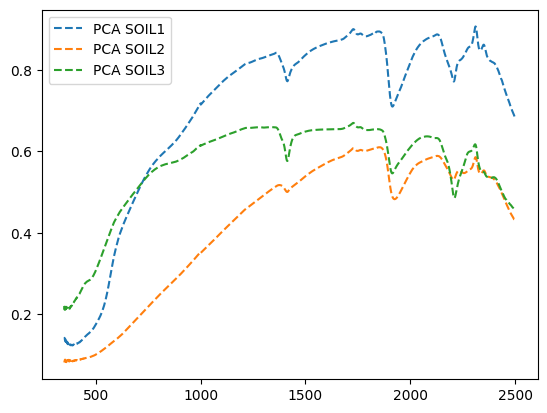

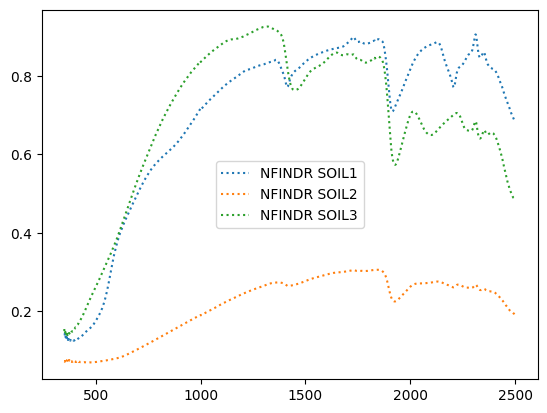

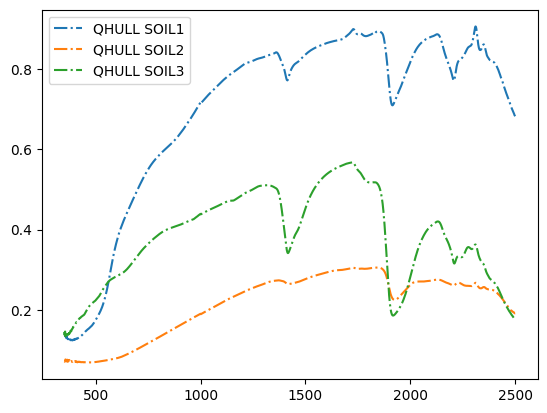

In [6]:
pca_soil_df.plot(linestyle='--')
nfindr_soil_df.plot(linestyle=':')
qhull_soil_df.plot(linestyle='-.')

In [11]:
pca_soil_df.index.name='Wavelength'
nfindr_soil_df.name='Wavelength'
qhull_soil_df.name='Wavelength'

In [12]:
pca_soil_df.to_csv('soil_members_pca.csv')
nfindr_soil_df.to_csv('soil_members_nfindr.csv')
qhull_soil_df.to_csv('soil_members_qhull.csv')

###  Compare to emit endmembers

<Axes: >

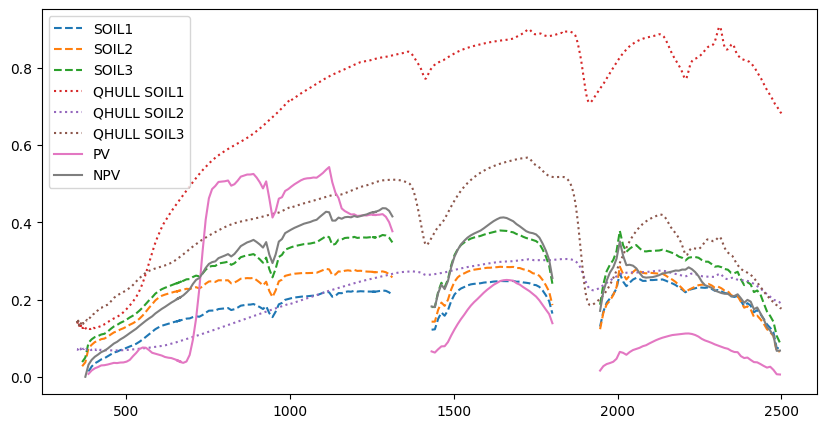

In [6]:
# compare to emit endmembers
emit_basic_em_file = "/Users/Fangyuan/Documents/Projects/SpectralUnmixing/data/basic_endmember_library.csv"

emit_basic_endmembers = pd.read_csv(emit_basic_em_file, index_col=0).T
emit_basic_endmembers.replace(0, np.nan, inplace=True)
emit_basic_endmembers.columns = ['SOIL1', 'SOIL2', 'SOIL3', 'PV', 'NPV']
emit_basic_endmembers = emit_basic_endmembers/10000
emit_basic_endmembers.index = emit_basic_endmembers.index.astype(float)

fig, ax = plt.subplots(figsize=(10, 5))

emit_basic_endmembers[['SOIL1', 'SOIL2', 'SOIL3']].plot(ax=ax, linestyle='--')
qhull_soil_df.plot(ax=ax, linestyle=':')
emit_basic_endmembers[['PV', 'NPV']].plot(ax=ax)


## Load data for testing

In [ ]:
# Pivot near Canberra
min_lat, max_lat = -35.32, -35.30
min_lon, max_lon = 149.16, 149.18

emit_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230316T045211_2307503_006/EMIT_L2A_RFL_001_20230316T045211_2307503_006_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240325T002836_2408415_019/EMIT_L2A_RFL_001_20240325T002836_2408415_019_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240901T013648_2424501_059/EMIT_L2A_RFL_001_20240901T013648_2424501_059_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240923T002255_2426615_009/EMIT_L2A_RFL_001_20240923T002255_2426615_009_masked.tif',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20241029T023534_2430302_057/EMIT_L2A_RFL_001_20241029T023534_2430302_057_masked.tif',
]

zarr_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230316T045211_2307503_006/EMIT_L2A_RFL_001_20230316T045211_2307503_006_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240325T002836_2408415_019/EMIT_L2A_RFL_001_20240325T002836_2408415_019_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240901T013648_2424501_059/EMIT_L2A_RFL_001_20240901T013648_2424501_059_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240923T002255_2426615_009/EMIT_L2A_RFL_001_20240923T002255_2426615_009_masked.zarr',
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20241029T023534_2430302_057/EMIT_L2A_RFL_001_20241029T023534_2430302_057_masked.zarr',
]


In [ ]:
# Irrigation area in VIC
min_lat, max_lat = -38.1, -38.0
min_lon, max_lon = 146.8, 147.0

emit_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250305T004702_2506401_039/EMIT_L2A_RFL_001_20250305T004702_2506401_039_masked.tif'
]

zarr_paths = [
    '/mnt/frontiersi-hyperspectral/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250305T004702_2506401_039/EMIT_L2A_RFL_001_20250305T004702_2506401_039_masked.zarr'
]

enmap_paths = [
    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000063368_20240229T005105Z_015_V010401_20240306T141210Z-SPECTRAL_IMAGE_COG.TIF',
#    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000064649_20240308T005824Z_002_V010401_20240309T171044Z-SPECTRAL_IMAGE_COG.TIF',
#    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000064649_20240308T005828Z_003_V010401_20240309T171343Z-SPECTRAL_IMAGE_COG.TIF'
]

In [7]:
# Irrigation area in VIC
min_lat, max_lat = -38.1, -38.0
min_lon, max_lon = 146.8, 147.0

emit_paths = [
    '../data/aus/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250305T004702_2506401_039/EMIT_L2A_RFL_001_20250305T004702_2506401_039_masked.tif'
]

enmap_paths = [
    '../data/ENMAP/ENMAP01-____L2A-DT0000063368_20240229T005105Z_015_V010401_20240306T141210Z-SPECTRAL_IMAGE_COG.TIF',
#    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000064649_20240308T005824Z_002_V010401_20240309T171044Z-SPECTRAL_IMAGE_COG.TIF',
#    '/mnt/frontiersi-hyperspectral/ENMAP/ENMAP01-____L2A-DT0000064649_20240308T005828Z_003_V010401_20240309T171343Z-SPECTRAL_IMAGE_COG.TIF'
]

## Load EMIT

In [10]:
%%time

ds_stack = []
for i in range(len(emit_paths)):
    tif_path = emit_paths[i]
    # time dimension
    date_time_obj = datetime.strptime(Path(tif_path).name.split('_')[4], "%Y%m%dT%H%M%S")
    
    ds_subset = rxr.open_rasterio(tif_path, chunks={}).sel(y=slice(max_lat, min_lat), x=slice(min_lon, max_lon))
    if np.min(ds_subset.shape)>0:
        ds_subset = ds_subset.compute()
        if len(ds_stack)>0:
            ds_subset = ds_subset.rio.reproject_match(ds_stack[0], resampling = Resampling.nearest)
        
        ds_stack.append(ds_subset.expand_dims(dim={"time":[date_time_obj]}))
    else:
        print("no data found in", tif_path)

ds_emit = xr.concat(ds_stack, dim="time")
ds_emit['band'] = np.array(ds_emit.attrs['long_name']).astype(int)

CPU times: user 266 ms, sys: 65.2 ms, total: 331 ms
Wall time: 464 ms


In [11]:
ndvi_emit = (ds_emit.sel(band=842, method='nearest') - ds_emit.sel(band=665, method='nearest')) / (ds_emit.sel(band=842, method='nearest') + ds_emit.sel(band=665, method='nearest'))

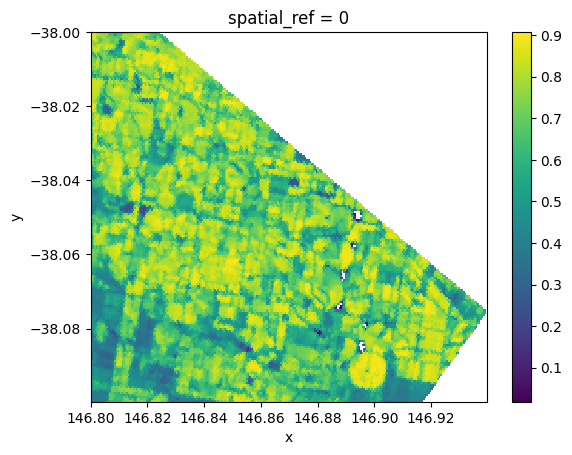

In [13]:
mask = ndvi_emit.min(dim='time')>0
ndvi_emit.mean(dim='time').where(mask).plot.imshow();

In [14]:
ds_emit_masked = ds_emit.where(mask)

## Load ENMAP

In [15]:
%%time

ds_stack = []
for i in range(len(enmap_paths)):
    tif_path = enmap_paths[i]
    # time dimension
    date_time_obj = datetime.strptime(Path(tif_path).name.split('_')[5], "%Y%m%dT%H%M%SZ")
    
    ds_subset = rxr.open_rasterio(tif_path, chunks={}).rio.reproject_match(ds_emit, resampling = Resampling.nearest).sel(y=slice(max_lat, min_lat), x=slice(min_lon, max_lon))
    if np.min(ds_subset.shape)>0:
        ds_subset = ds_subset.compute()
        if len(ds_stack)>0:
            ds_subset = ds_subset.rio.reproject_match(ds_stack[0], resampling = Resampling.nearest)
        
        ds_stack.append(ds_subset.expand_dims(dim={"time":[date_time_obj]}))
    else:
        print("no data found in", tif_path)

ds_enmap = xr.concat(ds_stack, dim="time")
ds_enmap = ds_enmap.where(ds_enmap>0, np.nan)/10000.
enmap_wavelengths = pd.read_csv('../src/enmap_wavelengths.csv')
ds_enmap['band'] = enmap_wavelengths.cw.values

CPU times: user 3.47 s, sys: 347 ms, total: 3.82 s
Wall time: 3.97 s


In [16]:
# Define the valid wavelength ranges
emit_bad_ranges = [(0, 440), (1310, 1490), (1770, 2050), (2440, 2880)]
enmap_bad_ranges = [(0, 440), (900,1000), (1310, 1490), (1770, 2050), (2440, 2880)]

# Function to check if a wavelength is outside the valid ranges
def is_outside_range(wavelength, ranges):
    return not any(start <= wavelength <= end for start, end in ranges)

# Get the indices of the bands that fall outside the ranges
good_emit = [is_outside_range(wavelength, emit_bad_ranges) for wavelength in ds_emit.band]
good_enmap = [is_outside_range(wavelength, enmap_bad_ranges) for wavelength in enmap_wavelengths.cw.values]

ds_emit = ds_emit.isel(band = good_emit)
ds_emit_masked = ds_emit_masked.isel(band = good_emit)
ds_enmap =ds_enmap.isel(band = good_enmap)

In [17]:
#this is not right, need to convert band number to wavelengths
ndvi_enmap = (ds_enmap.sel(band=842, method='nearest') - ds_enmap.sel(band=665, method='nearest')) / (ds_enmap.sel(band=842, method='nearest') + ds_enmap.sel(band=665, method='nearest'))

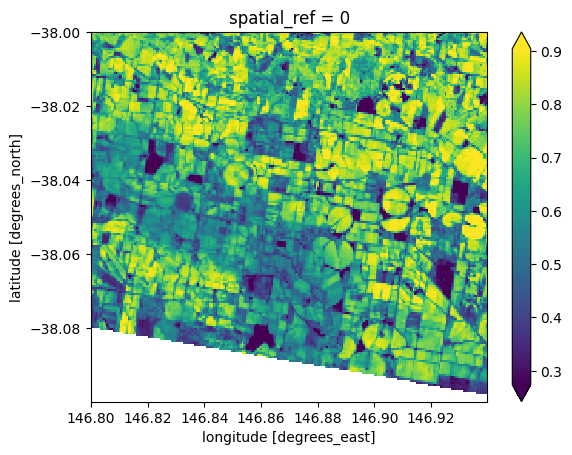

In [18]:
ndvi_enmap.min(dim='time').plot.imshow(robust=True);

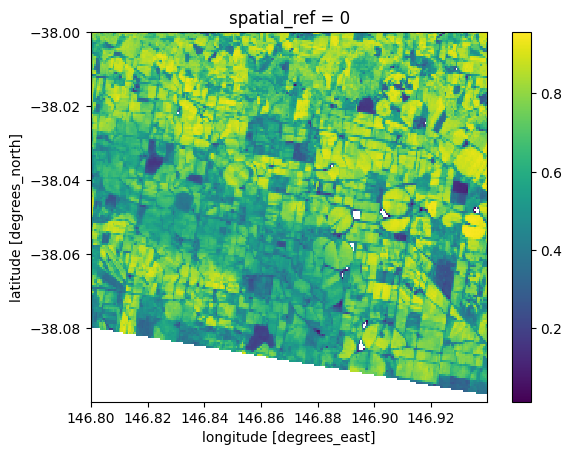

In [19]:
ndvi_enmap.mean(dim='time').where(ndvi_enmap.min(dim='time')>0).plot.imshow();

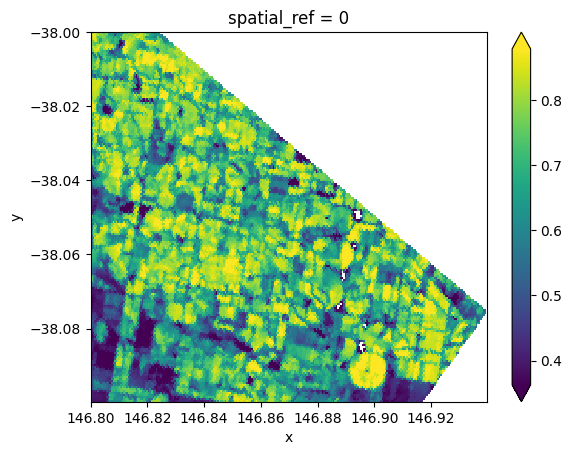

In [20]:
ndvi_emit.min(dim='time').where(mask).plot.imshow(robust=True);

### Try Unmixing


In [21]:
ds = ds_emit_masked

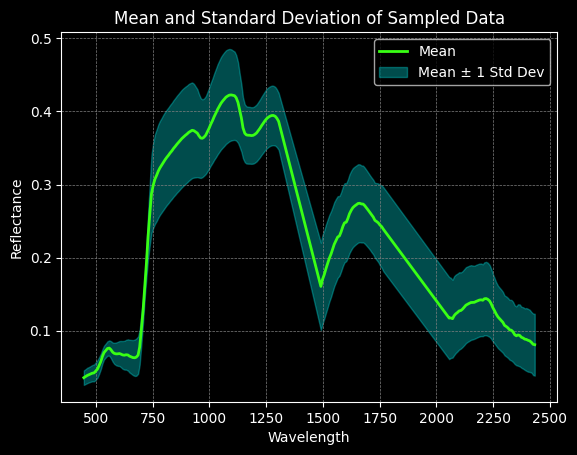

In [22]:
# Set the black background
plt.style.use('dark_background')

mean = ds.isel(time=0).mean(['y','x'])
std_dev = ds.isel(time=0).std(['y','x'])

mean = mean.where(mean>0)
std_dev = std_dev.where(std_dev>0)

mean.plot(label='Mean', color='#39FF14', linewidth=2)  # Neon green line

plt.fill_between(mean.band, mean - std_dev, mean + std_dev, color='#00FFFF', alpha=0.3, label='Mean ± 1 Std Dev')  # Neon cyan shading

# Customize the plot with labels, title, legend, and grid
plt.xlabel('Wavelength', color='white')
plt.ylabel('Reflectance', color='white')
plt.title('Mean and Standard Deviation of Sampled Data', color='white')
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)


## Clean the DATA

In [23]:
wavelengths = ds.band
dat = ds.transpose('band','y','x','time').data
# Reshape to (bands, pixels)
dat = dat.reshape((dat.shape[0], -1))
valid = ~np.any(np.isnan(dat), axis=0)
dat = dat[:, valid]

# Find the indicies of the bands where the minumum is all less than 0
bad_bands = np.all(dat < 0, axis=1)
print(f'Bad bands: {np.where(bad_bands)[0]}')

Bad bands: []


In [24]:
print("Shape:", dat.shape)

# Remove wild values
dat = dat[:, np.nanmax(dat, axis=0) < 0.9]
print("Shape after removing wild values:", dat.shape)


if dat.shape[1] > 1000000:
    # Remove outliers using sklearn IsolationForest
    clf = IsolationForest(contamination=0.05)
    outliers = clf.fit_predict(dat.T)
    sampled_data = dat[:, outliers == 1].T
    # Print the proportion of outliers
    print(f'Proportion of outliers: {np.sum(outliers == -1) / len(outliers)}')

    # Subsample a maximum of 1 million pixels
    num_samples = 1000000
    sample_pixels = np.random.choice(sampled_data.shape[0], min(num_samples,sampled_data.shape[0]), replace=False)
    sampled_data = sampled_data[sample_pixels]
else:
    sampled_data = dat.T
    
print(sampled_data.shape)

Shape: (206, 25124)
Shape after removing wild values: (206, 25124)
(25124, 206)


### SMACC

In [25]:
def plot_endmembers(wavelengths, endmembers, title = '', legend_labels = []):
    """
    Plot endmember spectra with wavelengths.
    
    Parameters:
    - wavelengths: ndarray of shape (n_bands,), wavelength values
    - endmembers: ndarray of shape (n_endmembers, n_bands), endmember spectra
    """
    with plt.style.context('dark_background'):
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        
        # Vectorized plotting using numpy operations
        wavelengths_matrix = np.tile(wavelengths, (endmembers.shape[0], 1)).T
        
        # Plot all lines at once with optimized line properties
        #lines = ax.plot(wavelengths_matrix, endmembers.T, 
        #               linewidth=1.5,  # Optimal line width for performance
        #               solid_capstyle='round',
        #               antialiased=True)
        for i in range(endmembers.shape[0]):
            ax.scatter(wavelengths, endmembers[i, :], 
                s=10,  # marker size
                alpha=0.7,  # transparency for overlap visibility
                label=f'Endmember {i+1}')
        
        ax.set_prop_cycle('color', plt.cm.tab10(np.linspace(0, 1, endmembers.shape[0])))
        
        ax.set(xlabel='Wavelength',
               ylabel='Reflectance',
               title=title)
        
        for text in (*ax.get_xticklabels(), *ax.get_yticklabels(),
                    ax.xaxis.label, ax.yaxis.label, ax.title):
            text.set_color('white')

        if len(legend_labels) ==0: legend_labels =[f'Endmember {i+1}' for i in range(endmembers.shape[0])]
        ax.legend(legend_labels,
                  framealpha=0.8,
                  loc='best',
                  ncol=1)

        ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        fig.tight_layout()


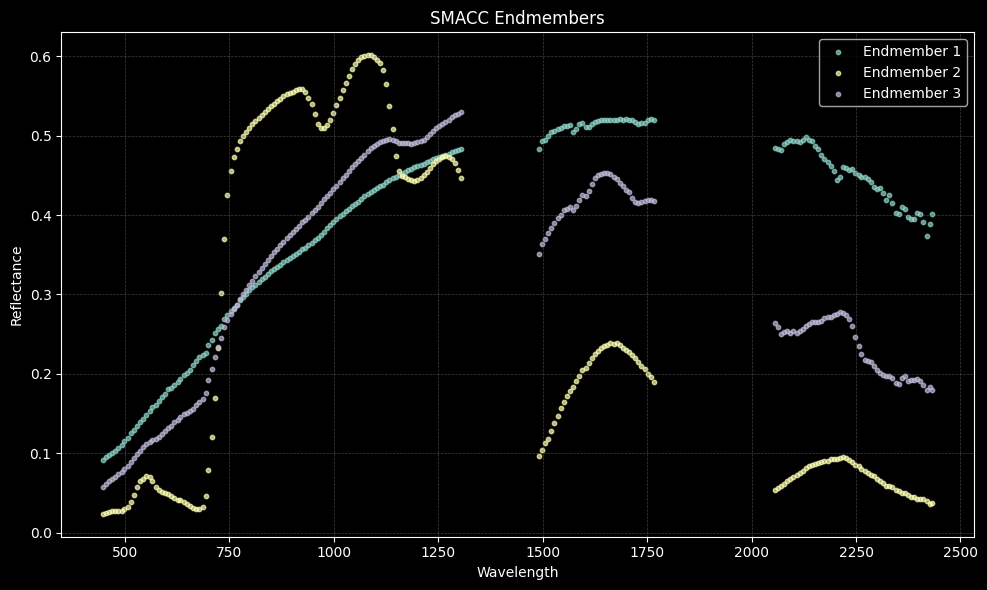

In [35]:
# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S, F, R = smacc(sampled_data[:, valid_bands], min_endmembers=3, max_residual_norm=1)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='SMACC Endmembers')

smacc_endmembers = endmembers

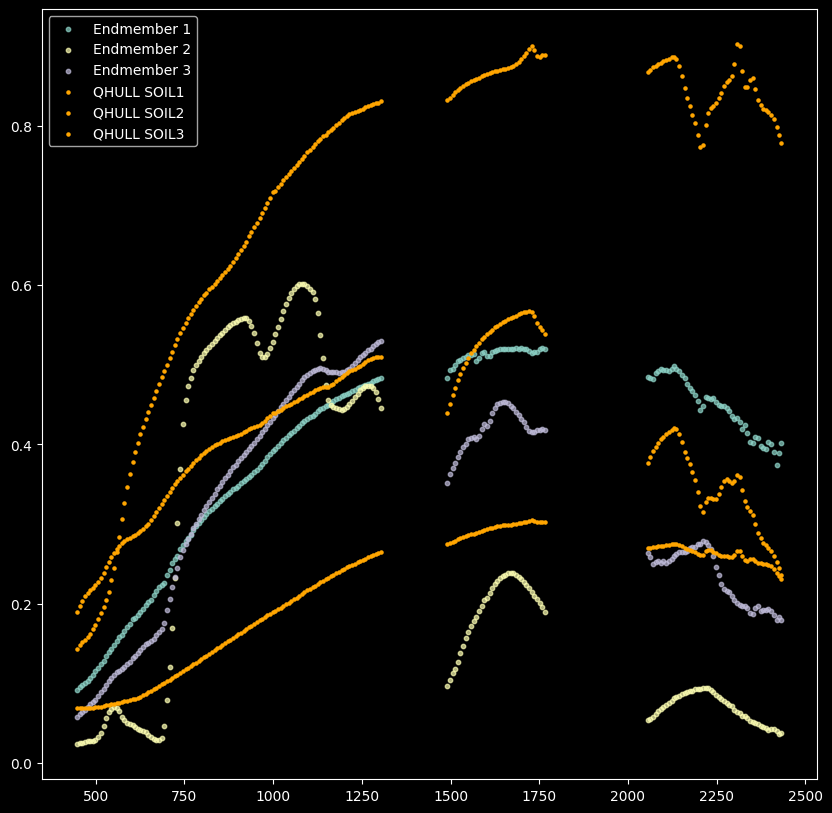

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
# Vectorized plotting using numpy operations
for i in range(endmembers.shape[0]):
            ax.scatter(wavelengths, endmembers[i, :], 
                s=10,  # marker size
                alpha=0.7,  # transparency for overlap visibility
                label=f'Endmember {i+1}')
            
for col in qhull_soil_df.columns:
        soil_endmember = np.interp(wavelengths, qhull_soil_df.index, qhull_soil_df[col])
        ax.scatter(wavelengths, soil_endmember, color='orange',
                s=5,  # marker size
                label=col)
            
plt.legend()

### QHULL

Cumulative PCA Explained Variance = [0.7149683  0.98054445 0.99339783]


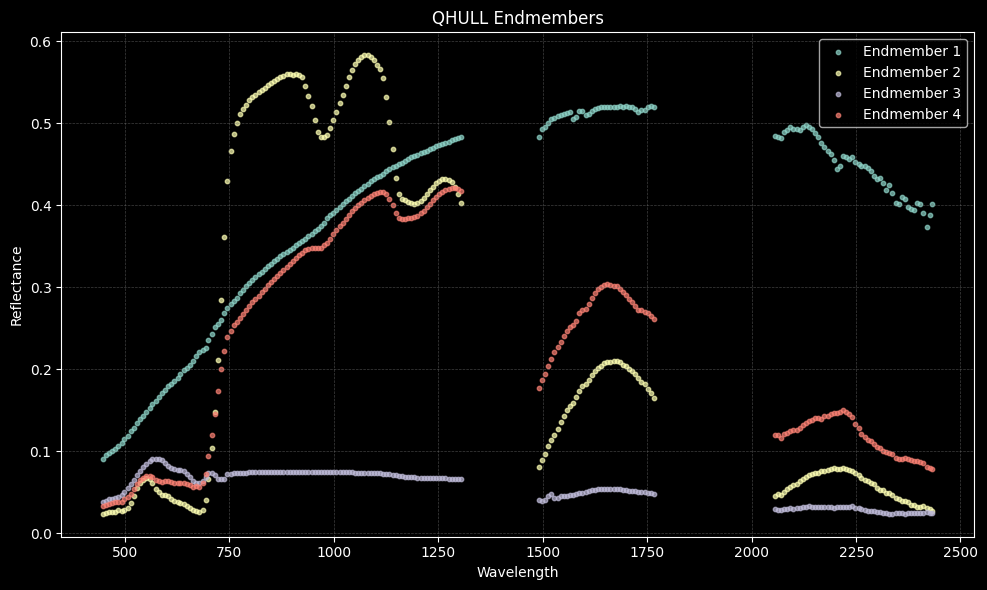

In [36]:

# Use boolean indexing more efficiently by computing mask once
valid_bands = ~np.all(sampled_data < 0, axis=0)

# Get endmembers for valid bands only
S = qhull(sampled_data[:, valid_bands], 3)

# Pre-allocate array with np.full
endmembers = np.full((S.shape[0], sampled_data.shape[1]), np.nan, dtype=np.float32)
endmembers[:, valid_bands] = S

plot_endmembers(wavelengths, endmembers, title='QHULL Endmembers')
qhull_endmembers = endmembers

## Unmixing

In [64]:
def unmix_nnls(ds, endmembers):

    ds = ds.where(ds>0, 0)
    data = ds.isel(time=0).transpose('band','y','x').data
    mask = np.all(data==0, axis=0) 

    # Setup inputs, outputs, and other configurations
    sum_to_one = endmembers.shape[0]
    weighted_endmembers = np.vstack((endmembers.T, np.ones(endmembers.shape[0]) * sum_to_one))

    # Flatten reflectance and perform PCA in one step to save memory
    original_shape = data.shape
    nbar_transformed = data.reshape(original_shape[0], -1)

    # Precompute ones array outside the loop
    ones_array = np.full((1, nbar_transformed.shape[1]), sum_to_one)

    # Combine weighted reflectance with ones_array using np.vstack
    weightedReflectance = np.vstack((nbar_transformed, ones_array))

    # Initialize fractions array with zeros
    fractions_nnls = np.zeros((weighted_endmembers.shape[1], nbar_transformed.shape[1]), dtype=np.float32)

    # Use vectorization where possible
    for i in range(weightedReflectance.shape[1]):
        fractions_nnls[:, i], _ = nnls(weighted_endmembers, weightedReflectance[:, i])

    # Reshape, clip, and convert to 8-bit data
    fractions = np.clip(np.rint(100.0 * fractions_nnls.reshape((-1,original_shape[1], original_shape[2]))), 0, 200).astype('uint8')

    # Compute fractions for bare, green, dry vegetation
    fractions_bgd = np.zeros((3, original_shape[1], original_shape[2]), dtype=np.uint8)
    fractions_bgd[0] = fractions[bare_green_dry[0]].sum(axis=0)
    fractions_bgd[1] = fractions[bare_green_dry[1]].sum(axis=0)
    fractions_bgd[2] = fractions[bare_green_dry[2]].sum(axis=0)

    # Apply mask
    fractions_bgd[:, mask] = 255
    fractions[:, mask] = 255

    print("Average difference to total of 100%", (fractions[:, ~mask].sum(axis=0)-100.).mean())

    return fractions_nnls, fractions, fractions_bgd

Average difference to total of 100% 0.02738555056037485


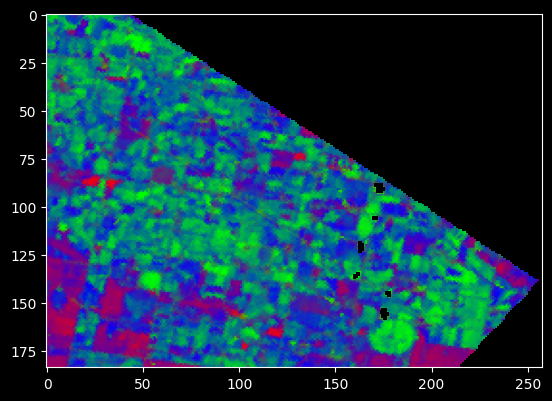

In [65]:
endmembers = []
# replace soil endmember with typical soil
for col in qhull_soil_df.columns:
    endmembers.append(np.interp(wavelengths, qhull_soil_df.index, qhull_soil_df[col]))

n_soil = len(qhull_soil_df.columns)
endmembers = np.vstack((np.array(endmembers), qhull_endmembers[1:]))
bare_green_dry = [list(range(n_soil)), [n_soil,n_soil+1], [n_soil+2]] # Bare, green, dry endmember mapping

ds = ds_emit_masked
fractions_nnls, fractions, fractions_bgd= unmix_nnls(ds, endmembers)

clipped_arr = np.transpose(fractions_bgd, (1, 2, 0))
clipped_arr = np.where((clipped_arr < 255), clipped_arr, np.nan)/100.
plt.imshow(clipped_arr)

Average difference to total of 100% 0.08782371936934084


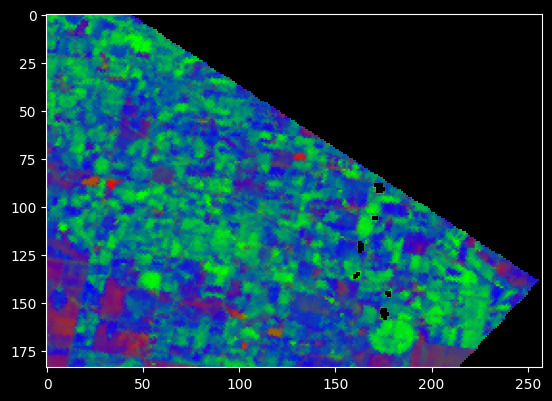

In [66]:
endmembers = qhull_endmembers
bare_green_dry = [[0],[1,2], [3]] # Bare, green, dry endmember mapping

ds = ds_emit_masked
fractions_nnls, fractions, fractions_bgd= unmix_nnls(ds, endmembers)

clipped_arr = np.transpose(fractions_bgd, (1, 2, 0))
clipped_arr = np.where((clipped_arr < 255), clipped_arr, np.nan)/100.
plt.imshow(clipped_arr)

Average difference to total of 100% 0.08436048165355077


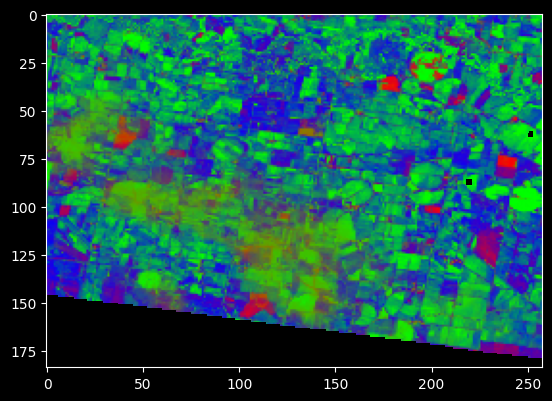

In [67]:
# Try ENMAP

endmembers = []
# replace soil endmember with typical soil
for col in qhull_soil_df.columns:
    endmembers.append(np.interp(ds_enmap.band.values, qhull_soil_df.index, qhull_soil_df[col]))

for i in range(qhull_endmembers.shape[0])[1:]:
    endmembers.append(np.interp(ds_enmap.band.values, wavelengths, qhull_endmembers[i,]))

endmembers = np.array(endmembers)
n_soil = len(qhull_soil_df.columns)
bare_green_dry = [list(range(n_soil)), [n_soil,n_soil+1], [n_soil+2]] # Bare, green, dry endmember mapping

ds = ds_enmap
fractions_nnls, fractions, fractions_bgd= unmix_nnls(ds, endmembers)

clipped_arr = np.transpose(fractions_bgd, (1, 2, 0))
clipped_arr = np.where((clipped_arr <=100), clipped_arr, np.nan)/100.
plt.imshow(clipped_arr)

Average difference to total of 100% 0.5683369678581587


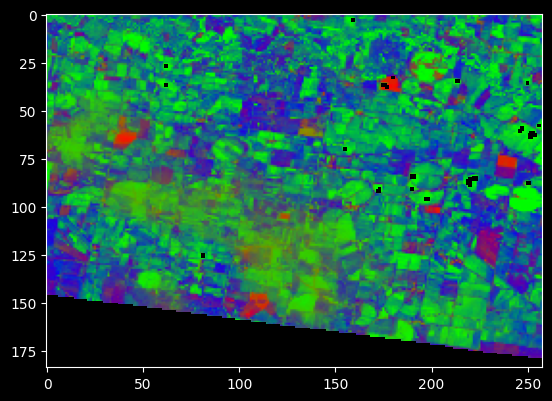

In [68]:
# Try ENMAP

endmembers = []
for i in range(qhull_endmembers.shape[0]):
    endmembers.append(np.interp(ds_enmap.band.values, wavelengths, qhull_endmembers[i,]))

endmembers = np.array(endmembers)
bare_green_dry = [[0],[1,2], [3]] # Bare, green, dry endmember mapping

ds = ds_enmap
fractions_nnls, fractions, fractions_bgd= unmix_nnls(ds, endmembers)

clipped_arr = np.transpose(fractions_bgd, (1, 2, 0))
clipped_arr = np.where((clipped_arr <=100), clipped_arr, np.nan)/100.
plt.imshow(clipped_arr)

0.08782371936934084


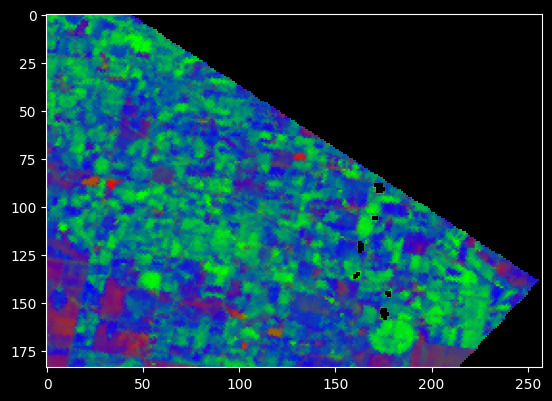

In [47]:
endmembers = qhull_endmembers
bare_green_dry = [[0], [1,2], [3]] # Bare, green, dry endmember mapping

ds = ds_emit_masked
fractions_nnls, fractions, fractions_bgd= unmix_nnls(ds, endmembers)

print((fractions[:, ~mask].sum(axis=0)-100.).mean())
clipped_arr = np.transpose(fractions_bgd, (1, 2, 0))
clipped_arr = np.where((clipped_arr < 255), clipped_arr, np.nan)/100.
plt.imshow(clipped_arr)

-2.552175014246818


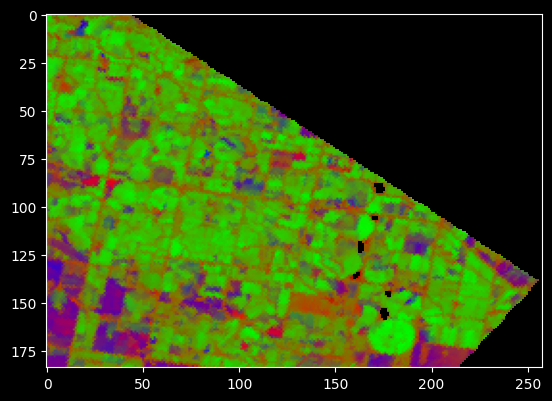

In [44]:
endmembers = []
# replace soil endmember with typical soil
for col in qhull_soil_df.columns:
    endmembers.append(np.interp(wavelengths, qhull_soil_df.index, qhull_soil_df[col]))

endmembers = np.vstack((np.array(endmembers), smacc_endmembers[1:]))
bare_green_dry = [list(range(n_soil)), [n_soil], [n_soil+1]] # Bare, green, dry endmember mapping

ds = ds_emit_masked
fractions_nnls, fractions, fractions_bgd= unmix_nnls(ds, endmembers)

print((fractions[:, ~mask].sum(axis=0)-100.).mean())
clipped_arr = np.transpose(fractions_bgd, (1, 2, 0))
clipped_arr = np.where((clipped_arr < 255), clipped_arr, np.nan)/100.
plt.imshow(clipped_arr)

### Fully constrained unmixing are slow to run and give similar results

In [ ]:
import time
from cvxopt import matrix, solvers

class FCLSU():
    def __init__(self):
        pass

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

    @staticmethod
    def _numpy_None_vstack(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.vstack([A1, A2])

    @staticmethod
    def _numpy_None_concatenate(A1, A2):
        if A1 is None:
            return A2
        else:
            return np.concatenate([A1, A2])

    @staticmethod
    def _numpy_to_cvxopt_matrix(A):
        A = np.array(A, dtype=np.float64)
        if A.ndim == 1:
            return matrix(A, (A.shape[0], 1), "d")
        else:
            return matrix(A, A.shape, "d")

    def solve(self, Y, E):
        """
        Performs fully constrained least squares of each pixel in M
        using the endmember signatures of U. Fully constrained least squares
        is least squares with the abundance sum-to-one constraint (ASC) and the
        abundance nonnegative constraint (ANC).
        Parameters:
            Y: `numpy array`
                2D data matrix (L x N).
            E: `numpy array`
                2D matrix of endmembers (L x p).
        Returns:
            X: `numpy array`
                2D abundance maps (p x N). d
        References:
            Daniel Heinz, Chein-I Chang, and Mark L.G. Fully Constrained
            Least-Squares Based Linear Unmixing. Althouse. IEEE. 1999.
        Notes:
            Three sources have been useful to build the algorithm:
                * The function hyperFclsMatlab, part of the Matlab Hyperspectral
                Toolbox of Isaac Gerg.
                * The Matlab (tm) help on lsqlin.
                * And the Python implementation of lsqlin by Valera Vishnevskiy, click:
                http://maggotroot.blogspot.ca/2013/11/constrained-linear-least-squares-in.html
                , it's great code.
        """
        tic = time.time()
        assert len(Y.shape) == 2
        assert len(E.shape) == 2

        L1, N = Y.shape
        L2, p = E.shape

        assert L1 == L2

        # Reshape to match implementation
        M = np.copy(Y.T)
        U = np.copy(E.T)

        solvers.options["show_progress"] = False

        U = U.astype(np.double)

        C = self._numpy_to_cvxopt_matrix(U.T)
        Q = C.T * C

        lb_A = -np.eye(p)
        lb = np.repeat(0, p)
        A = self._numpy_None_vstack(None, lb_A)
        b = self._numpy_None_concatenate(None, -lb)
        A = self._numpy_to_cvxopt_matrix(A)
        b = self._numpy_to_cvxopt_matrix(b)

        Aeq = self._numpy_to_cvxopt_matrix(np.ones((1, p)))
        beq = self._numpy_to_cvxopt_matrix(np.ones(1))

        M = np.array(M, dtype=np.float64)
        M = M.astype(np.double)
        X = np.zeros((N, p), dtype=np.float32)
        for n1 in range(N):
            d = matrix(M[n1], (L1, 1), "d")
            q = -d.T * C
    
            sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, None)["x"]
            X[n1] = np.array(sol).squeeze()
        tac = time.time()
        print(f"{self} took {tac - tic:.2f}s")
        return X.T
    
model = FCLSU()

# Endmembers extraction
E0 = endmembers.T # 2D matrix Lxp

# Call data to return HSI
n1, n2, n3 = data.shape
Y = data.reshape(n1, n2*n3)

# Abundances estimation
A0 = model.solve(Y, E0)

frac = A0.reshape(A0.shape[0], n2,n3)

# Reshape, clip, and convert to 8-bit data
frac = np.clip(np.rint(100.0 * frac.reshape((-1,original_shape[1], original_shape[2]))), 0, 200).astype('uint8')

# Compute fractions for bare, green, dry vegetation
frac_bgd = np.zeros((3, original_shape[1], original_shape[2]), dtype=np.uint8)
frac_bgd[0] = frac[bare_green_dry[0]].sum(axis=0)
frac_bgd[1] = frac[bare_green_dry[1]].sum(axis=0)
frac_bgd[2] = frac[bare_green_dry[2]].sum(axis=0)

# Apply mask
frac_bgd[:, mask] = 255
frac[:, mask] = 255

In [ ]:
(frac[:, ~mask].sum(axis=0)-100).mean(), (frac[:, ~mask].sum(axis=0)-100).std()

In [ ]:
plt.imshow(np.transpose(frac_bgd,(1, 2, 0)))

In [ ]:
idx = 8000
plt.plot(wavelengths, Y[:, idx] , label='Observed')
plt.plot(wavelengths, np.dot(A0.T, E0.T)[idx], label='Mixed')
for i in range(A0.shape[0]):
    plt.plot(wavelengths, A0[i, idx]*E0[:,i], label=f'Endmember {i} - {A0[i, idx]:0.2f}')
plt.legend()

In [ ]:
plt.plot(wavelengths, np.dot(A0.T, E0.T)[idx], label='Mixed')
for i in range(fractions_nnls.shape[0]):
    if i==0: mixed = fractions_nnls[i, idx]*E0[:,i]
    else: mixed+= fractions_nnls[i, idx]*E0[:,i]
    plt.plot(wavelengths, fractions_nnls[i, idx]*E0[:,i], label=f'Endmember {i} - {fractions_nnls[i, idx]:0.2f}')
plt.legend()